In [1]:
%load_ext autoreload
%autoreload 2
import bz2
import json

import pandas as pd

import texthero as hero

import texthero.preprocessing as hp

from helpers import *

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, jaccard_score
from sklearn.cluster import MiniBatchKMeans
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, LsiModel, TfidfModel, Word2Vec, FastText, Doc2Vec
import re
import string
import nltk

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nicolasbaldwin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:

def remove_verbs(series):
    """ function that removes all verbs from a series of sentences (series in the sense of pandas)"""
    def remove_verbs_from_sentence(sentence):
        """ function that removes all verbs from a sentence"""
        #tokenizes the sentence (makes it become a list of words)
        tokens = nltk.word_tokenize(sentence)

        #tags words, for example if the word is a verb in it's base form then it tags it with 'VB'
        #tagged becomes a list of tuples with (verb,tag) as format
        tagged = nltk.pos_tag(tokens)

        #filter all verbs from list
        tagged =list(filter(lambda x: x[1] not in  ['VB','VBD','VBG','VBN','VBP','VBZ','MD'],tagged))

        #remove tags from words
        words = list(map(lambda x: x[0], tagged))

        #join the words to have a sentence once againg
        sentence = ' '.join(words)
        return sentence

    return series.apply(remove_verbs_from_sentence)
  

## arguments:
    ## dataframe: dataframe containing quotes, the data frame must have at least 2 columns: 'party_label' and ' quotation'
    ## keyword: only used if use_keyword = True, allows us to do analysis with only quotes that include the keyword
    ## use_keyword: specifies if we must use the keyword to to do analysis with only quotes that include the keyword
    ##removeVerbs: if set to true, we remove all verbs from the quotes
    ## top: the number of trending words that will be shown on plot 
def trending_words(dataframe, keyword = None, use_keyword = False, removeVerbs = False, top = 20):
    """ function that plots on a bar plot the top trending words for every political party and compares it to the other partie's statistics """
    df = dataframe.copy()

    if use_keyword:
        #keep only quotes that contain the keyword
        df = df[df['quotation'].str.contains(keyword)]

    ##clean the data, (removing stop words etc..)
    df['quotation'] = clean(df['quotation'])

    if removeVerbs:
        #remove verbs from quotes
        df['quotation'] = remove_verbs(df['quotation'])

    ##count the top words per partylabel
    word_count = df.groupby('party_label')['quotation'].apply(hero.visualization.top_words)

    #rename columns
    word_count = word_count.reset_index().rename(columns = {'level_1': 'word', 'quotation': 'count'})

    #plot top trending words per party
    for party in word_count['party_label'].unique():
        #sort word frequency in decreasing order
        party_top_words = word_count[word_count['party_label'] == party].sort_values(by = 'count', ascending = False)
        if use_keyword:
            #drop keyword in the word frequencies
            party_top_words = party_top_words[party_top_words['word'] != keyword]

        ##get only the 'top' most frequent words
        party_top_words = party_top_words['word'].head(top)
        ##extract counts of the top trending words
        df_with_party_top_words = word_count[word_count['word'].isin(party_top_words)]
        #plot
        sns.barplot(data = df_with_party_top_words, y='word', x='count', hue='party_label').set_title('trending words for ' + party + ' party')
        plt.show()

#trending_words(df,keyword = 'trump',use_keyword = True,removeVerbs=True)

In [3]:
from sklearn.model_selection import cross_val_score

## arguments:
    ## dataframe: dataframe containing quotes, the data frame must have at least 2 columns: 'party_label' and ' quotation'
    ## keyword: only used if use_keyword = True, allows us to do analysis with only quotes that include the keyword
    ## use_keyword: specifies if we must use the keyword to to do analysis with only quotes that include the keyword
    ##removeVerbs: if set to true, we remove all verbs from the quotes
def pca(dataframe,keyword = None, use_keyword = False,removeVerbs = False):
    """ function that performs pca on quote and plots their position with respect to the 2 most meaningful vectors """
    df = dataframe.copy()
    #clean quote
    df['quotation'] = clean(df['quotation'])

    if use_keyword:
        #extract only quotes that include keyword
        df = df[df['quotation'].str.contains(keyword)]
        #remove keyword from quotes
        df['quotation'] = df['quotation'].apply(lambda x: x.replace(keyword, ''))

    if removeVerbs:
        #remove verbs from quotes
        df['quotation'] = remove_verbs(df['quotation'])

    #vectorization of the sentences
    df['tfidf'] = hero.tfidf(df['quotation'])
    #perform pca
    df['pca'] = hero.pca(df['tfidf'])
    #plot
    hero.scatterplot(
        df, 
        col='pca', 
        color='party_label', 
        title="PCA for quotes containing word " + keyword if use_keyword else '',
        hover_data = ['quotation','speaker']
    )


In [48]:
from sklearn.model_selection import cross_val_score
def random_forest_classification(dataframe,keyword = None, use_keyword = False,removeVerbs = False,n_estimators = 10 ,evaluation_metric = 'accuracy'):
    df = dataframe.copy()
    #clean quote

    if use_keyword:
        #extract only quotes that include keyword
        df = df[df['quotation'].str.contains(keyword)]
        #remove keyword from quotes
        df['quotation'] = df['quotation'].apply(lambda x: x.replace(keyword, ''))

    if removeVerbs:
        #remove verbs from quotes
        df['quotation'] = remove_verbs(df['quotation'])

    #vectorization of the sentences
    df['tfidf'] = hero.tfidf(df['quotation'])

    clf = RandomForestClassifier(n_estimators=n_estimators, max_features=0.8)

    scores = cross_val_score(clf, list(df['tfidf']), list(map(lambda x: 1 if x == 'D' else 0, df['party_label'])), cv=3)
    
    print('avergage crossValScore using '+ evaluation_metric +' as metric:' + str(scores.mean()))


In [5]:
def jaccard_sim(str_pair):
    if type(str_pair) != type(tuple()):
        return 0.0
    a = set(str_pair[0].split(' ')) 
    b = set(str_pair[1].split(' ')) 
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


In [6]:
PATH = 'data.nosync/processed/quotes-2020-party_labeled_cleaned.json.bz2'
df = pd.read_json(PATH, lines=True, compression='bz2')
df.head(2)

,quoteID,quotation,speaker,date,numOccurrences,id,party_label,US_congress_bio_ID
0,2020-01-16-000088,department homeland security livid strongly ur...,sue myrick,2020-01-16 12:00:13,1,Q367796,R,M001134
1,2020-01-26-000499,candidates better part world,dave loebsack,2020-01-26 13:21:36,11,Q771586,D,L000565


In [7]:
df.shape

(436608, 8)

In [8]:
from functools import partial
from itertools import combinations
import time
def remove_duplicates(dataframe,threshold):
    """removes quotes of speakers that have a jaccard similarity larger than a certain threshold"""
    def clean_row(row):
        """return the list of quotes that are going to be removed for
        one speaker because their jaccard similarity to another quote is
        larger than a certain threshold """
        to_remove = []
        
        #row is a the list of quotes of a speaker
        for i in range(len(row)):
            #check if we are above the maximum index because we are actively removing
            #quotes from the list that have already been determined to be removed
            # this done to optimize the algorithm 
            if(i >= len(row)):
                break
            row_i = row[i]
            for j in range(i+1,len(row)):
                #check if we are above the maximum index because we are actively removing
                #quotes from the list that have already been determined to be removed
                # this done to optimize the algorithm 
                if j >= len(row):
                    break
                row_j = row[j]
                sim = jaccard_sim((row_i,row_j))
                if sim > threshold:
                    #remove the shorter quote from row and add it to the to_remove list
                    if len(row_i) < len(row_j):
                        row.remove(row_i)
                        to_remove.append(row_i)
                        break
                    else:
                        row.remove(row_j)
                        to_remove.append(row_j)

        return to_remove

    df = dataframe
    #list of the dataframes that have been cleaned
    #every element of the list contains a dataframe wiht the quotes of a single speaker.
    #all quotes have a similarity < threshold among each other
    df_clean =[]

    #create a numbered id for every speaker (for optimization reasons (filtering a dataframe using an integer column is
    # slightly quicker than with a String column))
    speakers = df['speaker'].drop_duplicates()
    speaker_dict = dict(zip(speakers,range(0,len(speakers))))
    df['speaker_id'] = df['speaker'].apply(lambda x: speaker_dict[x])

    #group quotes by speaker ids and put them all in a list
    quotes_by_speaker = df.groupby('speaker_id').agg(lambda x: list(x)).reset_index()[['speaker_id','quotation']]
    for i,row in quotes_by_speaker.iterrows():
        #identify the quotes that must be removed because they're too similar to another
        sentences_to_remove = clean_row(row.quotation)

        #remove the 'duplicate' quotes
        filt = df[df['speaker_id'] == row.speaker_id]
        filt = filt[np.logical_not(filt['quotation'].isin(sentences_to_remove))]

        df_clean.append(filt)
    #concatenate all results together
    return pd.concat(df_clean).drop(columns= 'speaker_id')







In [9]:
display(df)
df =remove_duplicates(df,0.7)
display(df)

,quoteID,quotation,speaker,date,numOccurrences,id,party_label,US_congress_bio_ID
0,2020-01-16-000088,department homeland security livid strongly ur...,sue myrick,2020-01-16 12:00:13,1,Q367796,R,M001134
1,2020-01-26-000499,candidates better part world,dave loebsack,2020-01-26 13:21:36,11,Q771586,D,L000565
2,2020-01-26-040663,generational thing important quite honestly th...,dave loebsack,2020-01-26 13:21:36,11,Q771586,D,L000565
3,2020-01-20-000982,host protections,debbie lesko,2020-01-20 15:32:48,1,Q16731415,R,L000589
4,2020-01-09-060095,kidding way place leaks around,debbie lesko,2020-01-09 23:15:21,1,Q16731415,R,L000589
...,...,...,...,...,...,...,...,...
436603,2020-03-16-079753,embraced strict proper hygiene procedures hear...,robert abrams,2020-03-16 12:00:00,2,Q2156314,D,None
436604,2020-01-13-091997,important keep moving forward,laurie jinkins,2020-01-13 19:51:15,1,Q6501617,D,None
436605,2020-02-20-093793,want bill bring bill floor,j.t. wilcox,2020-02-20 22:12:45,1,Q6104393,R,None
436606,2020-01-20-084503,discover mythic superhero vanished years earli...,sylvester stallone,2020-01-20 10:30:00,1,Q40026,R,None


,quoteID,quotation,speaker,date,numOccurrences,id,party_label,US_congress_bio_ID
0,2020-01-16-000088,department homeland security livid strongly ur...,sue myrick,2020-01-16 12:00:13,1,Q367796,R,M001134
157265,2020-01-16-012811,cancel contracts train saudi police security f...,sue myrick,2020-01-16 00:00:00,2,Q367796,R,M001134
191091,2020-01-16-094237,block sale sensitive military munitions,sue myrick,2020-01-16 00:00:00,2,Q367796,R,M001134
213016,2020-02-28-013721,enlisted help hezbollah,sue myrick,2020-02-28 11:23:06,1,Q367796,R,M001134
213017,2020-02-28-034001,implies persian influence likely traced back i...,sue myrick,2020-02-28 11:23:06,1,Q367796,R,M001134
...,...,...,...,...,...,...,...,...
435985,2020-02-14-054657,affecting businesses also affecting every day ...,tim stine,2020-02-14 03:46:40,1,Q21064330,D,None
436210,2020-02-06-002083,nonprofit open doors help create kinds sponsor...,pat mcdonough,2020-02-06 18:14:24,2,Q7143736,R,None
436360,2020-02-07-000825,point border security initiative,roger hedgecock,2020-02-07 02:04:20,3,Q3439068,R,None
436434,2020-02-18-007399,city mayor issues important parking infrastruc...,daniel m. pierce,2020-02-18 00:14:22,1,Q18739817,D,None


In [11]:
PATH = 'data.nosync/processed/quotes-2020-party_no_duplicates.json.bz2'
with bz2.open(PATH, 'wb') as d_file:
    df.to_json(d_file, orient='records', lines=True)

In [ ]:
display(band)

,quoteID,quotation,speaker,date,numOccurrences,id,party_label,US_congress_bio_ID,speaker_id
0,2020-01-16-000088,department homeland security livid strongly ur...,sue myrick,2020-01-16 12:00:13,1,Q367796,R,M001134,0
1,2020-01-26-000499,candidates better part world,dave loebsack,2020-01-26 13:21:36,11,Q771586,D,L000565,1
2,2020-01-26-040663,generational thing important quite honestly th...,dave loebsack,2020-01-26 13:21:36,11,Q771586,D,L000565,1
3,2020-01-20-000982,host protections,debbie lesko,2020-01-20 15:32:48,1,Q16731415,R,L000589,2
4,2020-01-09-060095,kidding way place leaks around,debbie lesko,2020-01-09 23:15:21,1,Q16731415,R,L000589,2
...,...,...,...,...,...,...,...,...,...
433945,2020-02-23-017055,nevada put together multi generational multira...,elizabeth warren,2020-02-23 08:06:17,4,Q434706,D,W000817,3
433946,2020-02-10-042514,comes new hampshire,elizabeth warren,2020-02-10 23:14:00,4,Q434706,D,W000817,3
433947,2020-01-05-023397,look think people reasonably asking timing adm...,elizabeth warren,2020-01-05 15:13:19,1,Q434706,D,W000817,3
433948,2020-02-11-061543,new hampshire election night event,elizabeth warren,2020-02-11 11:01:00,1,Q434706,D,W000817,3


In [ ]:
df[df['speaker'].str.contains('aaron persky')]

,quoteID,quotation,speaker,date,numOccurrences,id,party_label,US_congress_bio_ID
14457,2020-02-14-090370,less moral culpability attached defendant lega...,aaron persky,2020-02-14 09:49:40,1,Q24506009,D,None


In [41]:
def plot_number_of_quotes_per_party(df):
    quotes_per_party = df[['party_label','quotation']].groupby('party_label').size().reset_index().rename(columns = {0: 'nb_quotes'})
    display(quotes_per_party)
    plt.bar(quotes_per_party.party_label,quotes_per_party.nb_quotes,color = ['blue','red'])
    plt.title('number of quotations per party')

,party_label,nb_quotes
0,D,234195
1,R,152498


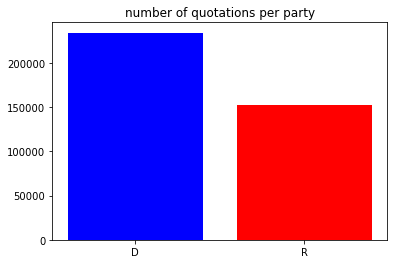

In [43]:
plot_number_of_quotes_per_party(df)



In [44]:
PATH = 'data.nosync/processed/quotes-2020-party_labeled_cleaned.json.bz2'
uncleaned_df = pd.read_json(PATH, lines=True, compression='bz2')


,party_label,nb_quotes
0,D,266424
1,R,170184


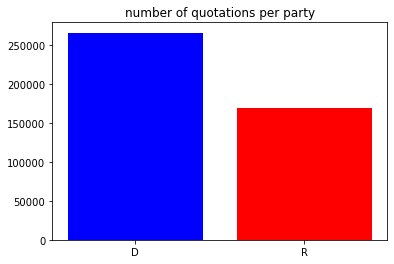

In [45]:
plot_number_of_quotes_per_party(uncleaned_df)

In [49]:
random_forest_classification(df.sample(n=100000),keyword = None, use_keyword = False,removeVerbs = False, evaluation_metric = 'f1',n_estimators = 10)

In [ ]:
kmean = MiniBatchKMeans(n_clusters = 2,random_state = 0, batch_size = 1000, max_iter =100).fit(hero.tfidf(df['quotation']))
